# **Import Library**

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Read Data**

In [2]:
data_train = pd.read_csv("/content/drive/Othercomputers/My Laptop/timeseries_submission/covid_19_indonesia_time_series_all.csv")
data_train

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,2020-03-01,ID-JK,DKI Jakarta,2,0,0,2,39,20,75,...,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,192.31%,NaN,NaN
1,2020-03-02,ID-JK,DKI Jakarta,2,0,0,2,41,20,75,...,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,182.93%,1.00,1.00
2,2020-03-02,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,2020-03-02,ID-RI,Riau,1,0,0,1,1,0,1,...,0.511648,0.16,0.16,0.0,0.00,0.00,0.00%,100.00%,NaN,NaN
4,2020-03-03,ID-JK,DKI Jakarta,2,0,0,2,43,20,75,...,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,174.42%,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31817,2022-09-15,ID-SA,Sulawesi Utara,37,0,0,37,52770,1213,50997,...,1.259638,14.01,19974.38,0.0,459.14,45.91,2.30%,96.64%,2.85,1.00
31818,2022-09-15,ID-SB,Sumatera Barat,13,0,3,10,104640,2371,102066,...,-0.850253,2.36,18959.11,0.0,429.59,42.96,2.27%,97.54%,6.50,1.00
31819,2022-09-15,ID-SS,Sumatera Selatan,16,0,1,15,82198,3376,78510,...,-3.216212,1.95,10002.74,0.0,410.83,41.08,4.11%,95.51%,3.20,1.00
31820,2022-09-15,ID-SU,Sumatera Utara,50,0,5,45,158866,3288,154924,...,2.191894,3.36,10680.15,0.0,221.04,22.10,2.07%,97.52%,1.92,1.00


# **Preprocessing**

In [3]:
data_train = data_train[['Date', 'New Cases']]
data_train

,Date,New Cases
0,2020-03-01,2
1,2020-03-02,2
2,2020-03-02,2
3,2020-03-02,1
4,2020-03-03,2
...,...,...
31817,2022-09-15,37
31818,2022-09-15,13
31819,2022-09-15,16
31820,2022-09-15,50


In [4]:
scaler = MinMaxScaler()
data_train['New Cases'] = scaler.fit_transform(data_train['New Cases'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


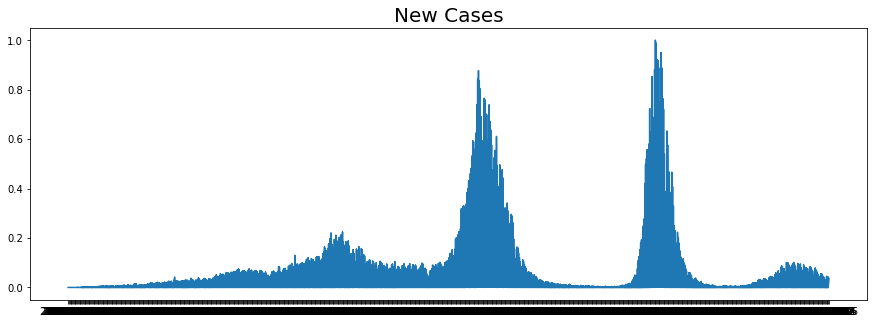

In [5]:
dates = data_train['Date'].values
cases  = data_train['New Cases']

plt.figure(figsize=(15,5))
plt.plot(dates, cases)
plt.title('New Cases', fontsize=20);

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
train_size = int(len(cases) * 0.8)
time = np.array(range(len(cases)))
series = np.array(cases)
time_train = time[:train_size]
x_train = series[:train_size]
time_valid = time[train_size:]
x_valid = series[train_size:]

In [8]:
train_set = windowed_dataset(
    x_train, window_size=60,
    batch_size=100,
    shuffle_buffer=1000)

valid_set = windowed_dataset(
    x_valid, window_size=60,
    batch_size=100,
    shuffle_buffer=1000)

In [9]:
for x, y in train_set.take(1):
    print(x[0])
    print(y[0])

tf.Tensor(
[[3.09033036e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.08161562e-04]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.09033036e-05]
 [1.54516518e-04]
 [4.63549553e-05]
 [1.23613214e-04]
 [1.54516518e-05]
 [1.08161562e-04]
 [4.63549553e-05]
 [9.27099107e-05]
 [0.00000000e+00]
 [2.31774777e-04]
 [2.31774777e-04]
 [0.00000000e+00]
 [2.68858741e-03]
 [1.54516518e-05]
 [4.63549553e-05]
 [5.87162768e-03]
 [1.54516518e-05]
 [1.08161562e-04]
 [2.31774777e-04]
 [2.00871473e-04]
 [1.23613214e-04]
 [1.39064866e-04]
 [1.54516518e-05]
 [1.39064866e-04]
 [1.23613214e-04]
 [1.54516518e-05]
 [1.08161562e-04]
 [7.72582589e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.23613214e-04]
 [0.00000000e+00]
 [9.27099107e-05]
 [4.63549553e-05]
 [7.72582589e-05]
 [0.00000000e+00]
 [4.17194598e-04]
 [0.00000000e+00]
 [4.63549553e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.78129732e-04]
 [1.54516518e-05]
 [0.00000000e+00]
 [1.69968170e-04]
 [1.39064866e-04]
 [0.00000000e+00]
 [2.62678080e-03]
 [1.54516518e-05]

# **Data Training**

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])

In [11]:
threshold_mae = (data_train['New Cases'].max() - data_train['New Cases'].min()) * 10/100

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<threshold_mae):
            print("mae < 10%")
            self.model.stop_training = True

callbacks = myCallback()

In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "accuracy"])

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set,
                    callbacks=[callbacks],
                    batch_size=128)


Epoch 1/20
    254/Unknown - 38s 120ms/step - loss: 8.1106e-04 - mae: 0.0073 - accuracy: 0.1093mae < 10%
254/254 [==============================] - 44s 146ms/step - loss: 8.1106e-04 - mae: 0.0073 - accuracy: 0.1093 - val_loss: 4.1277e-05 - val_mae: 0.0044 - val_accuracy: 0.2044


# **Plot**

# **MAE**

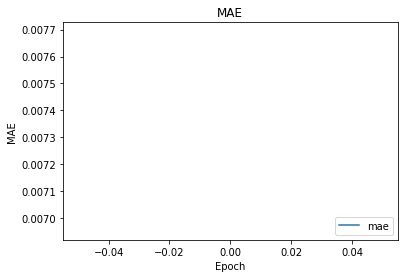

In [13]:
plt.plot(history.history['mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['mae'], loc='lower right')
plt.show()

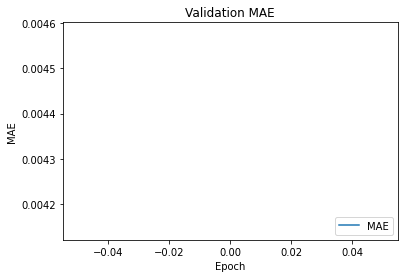

In [14]:
plt.plot(history.history['val_mae'])
plt.title('Validation MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['MAE'], loc='lower right')
plt.show()

## **Accuracy**

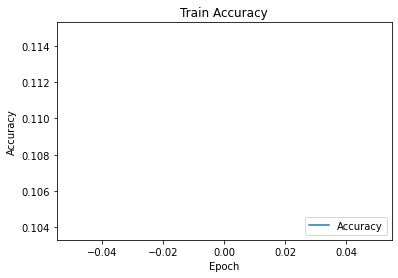

In [15]:
plt.plot(history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='lower right')
plt.show()

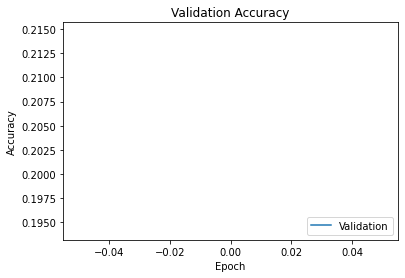

In [16]:
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='lower right')
plt.show()

## **Loss**

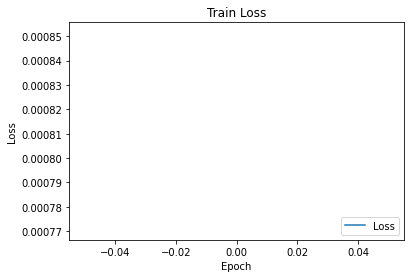

In [17]:
plt.plot(history.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='lower right')
plt.show()

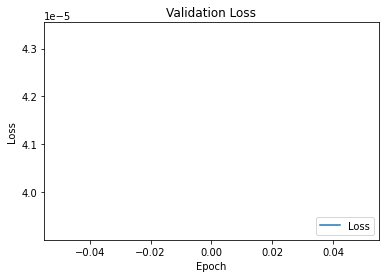

In [18]:
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='lower right')
plt.show()